# **Library Book Recommendation System**
---
Authors: [Monicah Iwagit](https://github.com/Okodoimonicah), [Bradley Azegele](https://github.com/Azegele), [Emmanuel Kipkorir](), [Belinda Nyamai](), [Femi Kamau](https://github.com/ctrl-Karugu), and [Dennis Kimiri]()

## 1. Business Understanding

### 1.1 Problem Statement
>The tremendous growth and usage of information has led to information overloading where users find it difficult to locate the right information at a specified time. Although there are previous studies conducted on library recommender systems, the datasets used were small compared to the dataset we intend to use hence minimal area coverage. Recommending the right library books is a challenge due to the variety of genres available and the huge collection of books provided. A user finds it difficult to select the most appropriate book that will suit their academic needs, this process consumes a lot of time that the user would have used to sharpen on their desired skills. Additionally, many books in the library are rarely utilized which results in a waste of library resources. Having a personalized recommendation system seeks to predict the preference based on the user’s interest, behavior and information. The application of recommender systems in a library set up solves the problem of difficulty in choosing books and improves utilization rate of library resources. 

## 2. Data Understanding
> The goal of the Data Understanding phase is to provide a solid foundation for the subsequent steps, including data preparation, exploratory data analysis, model development, and evaluation.

#### Load Libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
import warnings

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### 2.1 Collect Initial Data
> The goal of this section is to acquire the necessary data and load it into the notebook.

> The data used in this project was sourced from 2 different sources:
>   1. The first was source was from Cai-Nicolas Ziegler in a 4-week crawl (August-September [2004]) in the University of Freiburg, Germany. This can be found [here](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). The data obtained are 3 datasets with information on [users](./data/BX-Users.csv), [ratings](./data/BX-Book-Ratings.csv) and [books](./data/BX-Books.csv) from a library.
>
>   2. The second set of data was sourced from the [Google Books API](https://developers.google.com/books). This data was obtained by using ISBNs in the books dataset from the first source. The script used to extract the data can be found [here](./make_dataset.py). This data was then stored in csv format and can be found [here](./data/books.csv).

#### Load Data

In [2]:
# (Source 1)
ratings = pd.read_csv("data/BX-Book-Ratings.csv", sep=";", error_bad_lines=False, encoding="latin-1")
books = pd.read_csv("data/BX-Books.csv", sep=";", error_bad_lines=False, encoding="latin-1")
users = pd.read_csv("data/BX-Users.csv", sep=";", error_bad_lines=False, encoding="latin-1")

# (Source 2)
books_extra = pd.read_csv("data/api-books.csv", dtype={"join_isbn_10": str})

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


### 2.2 Describe Data
> The goal of this section is to examine the data and document its surface properties.

In [3]:
# Define class to describe the data 
class DescribeData():
    """This class is used to describe the data in a DataFrame."""
    
    def __init__(self, df) -> None:
        
        # Get the DataFrame
        self.df = df
        
        # Get the datatypes of the columns in the DataFrame
        self.datatypes = df.dtypes
         
        # Get the shape of the DataFrame
        self.shape = f"The shape of the DataFrame is {df.shape}\n\nRecords: {df.shape[0]}\nColumns: {df.shape[1]}"
        
        # Get the number of missing values in each column
        self.missing = f"There are a total of {df.isnull().sum().values.sum()} missing values in the DataFrame.\n\n{df.isnull().sum()}"
        
        # Get the number of duplicate rows
        self.duplicates = f"There are {df.duplicated().sum()} duplicated records in the DataFrame."

#### 2.2.1 `ratings`

In [4]:
# Create an instance of the 'DescribeData' class for the 'ratings' DataFrame
rt = DescribeData(ratings)

In [5]:
# Preview the 'ratings' DataFrame
rt.df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
# Inspect the information about the DataFrame
rt.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [7]:
# Inspect the shape of the DataFrame
print(rt.shape)

The shape of the DataFrame is (1149780, 3)

Records: 1149780
Columns: 3


In [8]:
# Inspect the datatypes of the columns in the DataFrame
print(rt.datatypes)

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object


In [9]:
# Inspect the summary statistics of the DataFrame
rt.df.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [10]:
# Inspect the number of missing values in each column
print(rt.missing)

There are a total of 0 missing values in the DataFrame.

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [11]:
# Inspect the duplicates in the DataFrame
print(rt.duplicates)

There are 0 duplicated records in the DataFrame.


[**Ratings Dataset**](./data/BX-Book-Ratings.csv)

>* Spans **3** columns and **1,149,780** rows.

>* Contains **2** unique datatypes: 
>    * **int64**
>    * **object**

>* Has no missing values

>* Has no duplicates

#### 2.2.2 `books` 

In [12]:
# Instantiate the 'DescribeData' class for the 'books' DataFrame
bk = DescribeData(books)

In [13]:
# Preview the 'books' DataFrame
bk.df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [14]:
# Inspect the information about the DataFrame
bk.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [15]:
# Inspect the shape of the DataFrame
print(bk.shape)

The shape of the DataFrame is (271360, 8)

Records: 271360
Columns: 8


In [16]:
# Inspect the datatypes of the columns in the DataFrame
print(bk.datatypes)

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object


In [17]:
# Inspect the missing values in the DataFrame
print(bk.missing)

There are a total of 6 missing values in the DataFrame.

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


In [18]:
# Inspect the duplicates in the DataFrame
print(bk.duplicates)

There are 0 duplicated records in the DataFrame.


[**Books Dataset**](./data/BX-Books.csv)

>* Spans **8** columns and **271,359** rows.

>* Contains 1 unique datatype: 
>   * **object**

>* Has **6** missing values:
>   * Book-Author: **1** 
>   * Publisher: **2**
>   * Image-URL-L: **3**

>* Has no duplicates

#### 2.2.3 `users` 

In [19]:
# Instantiate the 'DescribeData' class for the 'users' DataFrame
ur = DescribeData(users)

In [20]:
# Preview the 'users' DataFrame
ur.df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [21]:
# Inspect the information about the DataFrame
ur.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [22]:
# Inspect the shape of the DataFrame
print(ur.shape)

The shape of the DataFrame is (278858, 3)

Records: 278858
Columns: 3


In [23]:
# Inspect the datatypes of the columns in the DataFrame
print(ur.datatypes)

User-ID       int64
Location     object
Age         float64
dtype: object


In [24]:
# Inspect the summary statistics of the DataFrame
ur.df.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [25]:
# Inspect the missing values in the DataFrame
print(ur.missing)

There are a total of 110762 missing values in the DataFrame.

User-ID          0
Location         0
Age         110762
dtype: int64


In [26]:
# Inspect the duplicates in the DataFrame
print(ur.duplicates)

There are 0 duplicated records in the DataFrame.


[**Users Dataset**](./data/BX-Users.csv)

>* Spans **3** columns and **278,857** rows.

>* Contains **3** unique datatypes:
>   * **int64**
>   * **float64**
>   * **object**

>* Has **110762** missing values:
>   * Age: **110,762**

>* Has no duplicates

#### 2.2.4 `books_extra`

In [27]:
# Instantiate the 'DescribeData' class for the 'books_extra' DataFrame
bk_extra = DescribeData(books_extra)

In [28]:
# Preview the 'books_extra' DataFrame
bk_extra.df.head()

,authors,published_date,description,isbn_10,isbn_13,page_count,categories,maturity_rating,language,join_isbn_10
0,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",0195153448,9780195153446.0,808.0,['Social Science'],NOT_MATURE,en,0195153448
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0002005018
2,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",IND:30000026059836,NaN,582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",9780374157067,374157065.0,367.0,['Medical'],NOT_MATURE,en,0374157065
4,['E. J. W. Barber'],1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",0393045218,9780393045215.0,240.0,['Design'],NOT_MATURE,en,0393045218


In [29]:
# Inspect the information about the DataFrame
bk_extra.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271044 entries, 0 to 271043
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   authors          210684 non-null  object 
 1   published_date   212589 non-null  object 
 2   description      180298 non-null  object 
 3   isbn_10          212653 non-null  object 
 4   isbn_13          179739 non-null  object 
 5   page_count       211385 non-null  float64
 6   categories       199011 non-null  object 
 7   maturity_rating  212741 non-null  object 
 8   language         212741 non-null  object 
 9   join_isbn_10     271044 non-null  object 
dtypes: float64(1), object(9)
memory usage: 20.7+ MB


In [30]:
# Inspect the shape of the DataFrame
print(bk_extra.shape)

The shape of the DataFrame is (271044, 10)

Records: 271044
Columns: 10


In [31]:
# Inspect the datatypes of the columns in the DataFrame
print(bk_extra.datatypes)

authors             object
published_date      object
description         object
isbn_10             object
isbn_13             object
page_count         float64
categories          object
maturity_rating     object
language            object
join_isbn_10        object
dtype: object


In [32]:
# Inspect the summary statistics of the DataFrame
bk_extra.df.describe()

,page_count
count,211385.000000
mean,279.534995
std,179.001719
min,0.000000
25%,176.000000
50%,260.000000
75%,356.000000
max,3596.000000


In [33]:
# Inspect the missing values in the DataFrame
print(bk_extra.missing)

There are a total of 607555 missing values in the DataFrame.

authors            60360
published_date     58455
description        90746
isbn_10            58391
isbn_13            91305
page_count         59659
categories         72033
maturity_rating    58303
language           58303
join_isbn_10           0
dtype: int64


In [34]:
# Inspect the duplicates in the DataFrame
print(bk_extra.duplicates)

There are 0 duplicated records in the DataFrame.


[**Books (Extra) Dataset**](./data/books.csv)

>* Spans **10** columns and **()** rows.

>* Contains **2** unique datatypes:
>   * **float64**
>   * **object**

>* Has **()** missing values:

>* Has no duplicates

## 3. Data Preparation
> This is the process of identifying and correcting or removing incorrect, incomplete, or improperly formatted data in a dataset. It mainly involves handling missing values, fixing incorrect data, removing duplicates, normalizing data and handling outliers.

### Users Dataset

The location column has city, state and country separated by commas. We segregate these into 3 different columns so that we can analyse on the basis of the country of different users.

In [35]:
#splitting a string into a list
list_ = users.Location.str.split(', ')

#empty lists to add values  
city = []
state = []
country = []
count_no_state = 0    
count_no_country = 0
#generating a for loop to add values to the empty lists
for i in range(0,len(list_)):
    #removing invalid entries in city
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        #removing invalid entries in state
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':   
            state.append('other')
            count_no_state += 1            
        else:
            state.append(list_[i][1].lower())
        
        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            #removing invalid entries in country
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())
        
#dropping the location column from users             
users = users.drop('Location',axis=1)

#handling cases where city/state from the lists is already given
temp = []
for ent in city:
    c = ent.split('/')            
    temp.append(c[0])
    
#creating a dataframe for city, state and country
df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

#adding the new dataframes to the original users dataframe 
users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

#printing the number of countries that do not have values 
print(count_no_country)

#printing the states which didnt have any values
print(count_no_state)     

4659
16044


In [36]:
## Drop duplicate rows
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)

In [37]:
#confirming that the new dataframes have been added to users
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   User-ID  278858 non-null  int64  
 1   Age      168096 non-null  float64
 2   City     278858 non-null  object 
 3   State    278858 non-null  object 
 4   Country  278858 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 10.6+ MB


In [38]:
users.head()

,User-ID,Age,City,State,Country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom


In [39]:
# checking for null values
users['Age'].isnull().sum()

110762

#### Dealing with missing values in the Age column

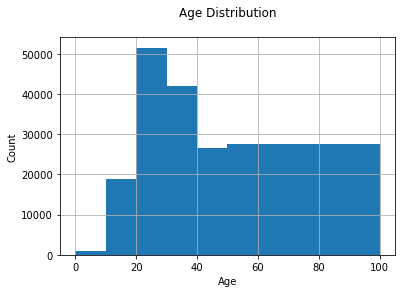

In [40]:
#checking the Age distribution
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

The most active users are in the age bracket between 20 to 30 years.

Text(0.5, 1.0, 'Outliers present in the Age column')

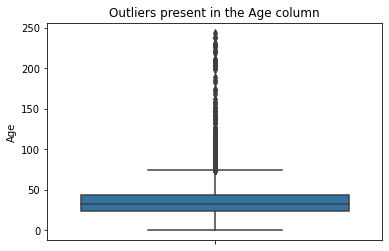

In [41]:
#checking for outliers in the age column using a boxplot
sns.boxplot(y='Age', data=users)
plt.title('Outliers present in the Age column')

Looking at the distribution plot the age is skewed to the right and has outliers. Replacing the missing age values and values less than 10 and greater than 80 with the median will be the robust approach since it's not sensitive to extreme values compared to using the mean.

In [42]:
#checking all values present in the Age column
print(sorted(list(users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

Text(0.5, 1.0, 'Age Distribution Plot')

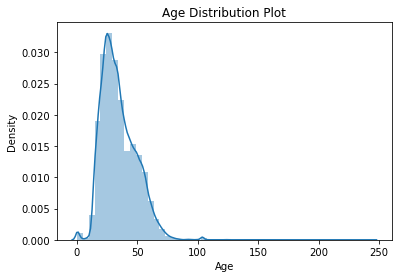

In [43]:
#plotting a distribution plot to discover the relevant age bracket 
sns.distplot(users.Age)
plt.title('Age Distribution Plot')

Evidently, users with ages less than 10 and above 80 are not an appropriate target for our book recommendation system since we assume they will not be able to access a library or use the recommendation system.

In [44]:
# Select rows where the age column is greater than 10 and less than 80
users_filtered = users[(users['Age'] >= 10) & (users['Age'] <= 80)]

In [45]:
# calculating the median for the required ages
median = users_filtered['Age'].median()
median

32.0

In [46]:
# Replace the entries less than 10 or greater than 80 with the median
users.loc[(users['Age'] < 10) | (users['Age'] > 80), 'Age'] = median

In [47]:
# Replace missing values in the "age" column with the median age
users['Age'] = users['Age'].fillna(median)

In [48]:
# convert the age column to int
users['Age'] = pd.to_numeric(users['Age'], downcast='integer')

In [49]:
print(sorted(list(users['Age'].unique())))

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]


In [50]:
#confirming that the missing values have been dealt with
users.isna().sum()

User-ID    0
Age        0
City       0
State      0
Country    0
dtype: int64

In [51]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int8  
 2   City     278858 non-null  object
 3   State    278858 non-null  object
 4   Country  278858 non-null  object
dtypes: int64(1), int8(1), object(3)
memory usage: 8.8+ MB


### Books Dataset

In [52]:
#checking the shape of the books dataset before dealing with erraneous ISBN values
books.shape

(271360, 8)

In [53]:
#converting the books ISBN numbers to upper string and replacing the quotation marks
books['ISBN'] = books['ISBN'].str.upper().str.replace(' ', '')

In [54]:
#checking for duplicates 
books['ISBN'].duplicated().sum()

314

In [55]:
#function to correct the ISBN that are not in correct format
def correct_isbn(isbn):
    isbn = str(isbn)
    fill = "0"
    if len(isbn) < 10:
        missing = 10 - len(isbn)
        new_isbn = (fill * missing) + isbn
        return new_isbn
    elif len(isbn) > 10:
        try:
            pattern = r"^[0-9Xx]{10}"
            result = re.search(pattern, isbn)
            new_isbn = result.group(0)
            return new_isbn
        except:
            print(isbn)
            return isbn

    return isbn

In [56]:
#applying the function to the books ISBN column
books['ISBN'] = books['ISBN'].apply(correct_isbn)

0486404242	
3518365479<90
34422480273
03857222060


In [57]:
#dropping duplicates
books.drop_duplicates(subset=['ISBN'], inplace=True)

In [58]:
#checking the shape of the new dataset after dealing with duplicates
books.shape

(271046, 8)

In [59]:
#merge books dataset to books_extra
books_data = books.merge(books_extra, right_on = 'join_isbn_10', left_on = 'ISBN', how = 'inner')

In [60]:
#Instantiate the 'DescribeData' class for the merged dataset
bk_upgrd = DescribeData(books_data)

In [61]:
bk_upgrd.df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,isbn_10,isbn_13,page_count,categories,maturity_rating,language,join_isbn_10
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",0195153448,9780195153446.0,808.0,['Social Science'],NOT_MATURE,en,0195153448
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0002005018
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",IND:30000026059836,NaN,582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",9780374157067,374157065.0,367.0,['Medical'],NOT_MATURE,en,0374157065
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg,['E. J. W. Barber'],1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",0393045218,9780393045215.0,240.0,['Design'],NOT_MATURE,en,0393045218


In [62]:
bk_upgrd.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271042 entries, 0 to 271041
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 271042 non-null  object 
 1   Book-Title           271042 non-null  object 
 2   Book-Author          271041 non-null  object 
 3   Year-Of-Publication  271042 non-null  object 
 4   Publisher            271040 non-null  object 
 5   Image-URL-S          271042 non-null  object 
 6   Image-URL-M          271042 non-null  object 
 7   Image-URL-L          271039 non-null  object 
 8   authors              210682 non-null  object 
 9   published_date       212587 non-null  object 
 10  description          180297 non-null  object 
 11  isbn_10              212651 non-null  object 
 12  isbn_13              179738 non-null  object 
 13  page_count           211383 non-null  float64
 14  categories           199010 non-null  object 
 15  maturity_rating  

In [63]:
print(bk_upgrd.missing)

There are a total of 607558 missing values in the DataFrame.

ISBN                       0
Book-Title                 0
Book-Author                1
Year-Of-Publication        0
Publisher                  2
Image-URL-S                0
Image-URL-M                0
Image-URL-L                3
authors                60360
published_date         58455
description            90745
isbn_10                58391
isbn_13                91304
page_count             59659
categories             72032
maturity_rating        58303
language               58303
join_isbn_10               0
dtype: int64


In [64]:
# define class for data cleaning
class DataCleaning:
    def __init__(self, data):
        self.data = data
        
    def drop_null_rows(self):
        """Drops rows with null values."""
        self.data = self.data.dropna()
        return self.data

    def drop_duplicate_rows(self):
        """Drops duplicate rows."""
        self.data = self.data.drop_duplicates()
        return self.data

    def handle_missing_values(self, column, method, value=None):
        """Handles missing values in a specified column.
        
        The method parameter take one of the following:
        "drop": Drops rows with missing values in the specified column.
        "fill": Fills missing values with the specified value.
        "interpolate": Interpolates missing values using linear interpolation.
        """
        if method == "drop":
            self.data = self.data.dropna(subset=[column])
        elif method == "fill":
            self.data[column] = self.data[column].fillna(value)
        elif method == "interpolate":
            self.data[column] = self.data[column].interpolate()
        else:
            raise ValueError("Invalid value for method parameter. Valid values are 'drop', 'fill', and 'interpolate'.")
        return self.data

    def convert_column_data_type(self, column, data_type):
        """Converts the data type of a specified column."""
        self.data[column] = self.data[column].astype(data_type)
        return self.data

In [65]:
#Instantiate the 'datacleaning' class for the merged dataset
data_cleaning = DataCleaning(books_data)

In [66]:
#dropping rows with null values in the description column
books_data = data_cleaning.handle_missing_values(column="description", method="drop")
books_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,isbn_10,isbn_13,page_count,categories,maturity_rating,language,join_isbn_10
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",0195153448,9780195153446.0,808.0,['Social Science'],NOT_MATURE,en,0195153448
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",IND:30000026059836,NaN,582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",9780374157067,374157065.0,367.0,['Medical'],NOT_MATURE,en,0374157065
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg,['E. J. W. Barber'],1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",0393045218,9780393045215.0,240.0,['Design'],NOT_MATURE,en,0393045218
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.LZZZZZZZ.jpg,['Amy Tan'],1991,"A Chinese immigrant who is convinced she is dying threatens to celebrate the Chinese New Year by unburdening herself of everybody's hidden truths, thus prompting a series of comic misunderstandings",0399135782,9780399135781.0,428.0,['Fiction'],NOT_MATURE,en,0399135782


All entries with no description are dropped because it is a critical feature that will be used in our recommendation system.

In [67]:
#dropping unwanted columns from the merged dataset
book_data = books_data.drop(['Image-URL-L', 'Image-URL-M','isbn_10', 'isbn_13','join_isbn_10'], axis=1)
book_data

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,published_date,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808.0,['Social Science'],NOT_MATURE,en
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",582.0,['1940-1949'],NOT_MATURE,en
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",367.0,['Medical'],NOT_MATURE,en
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,['E. J. W. Barber'],1999,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",240.0,['Design'],NOT_MATURE,en
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.THUMBZZZ.jpg,['Amy Tan'],1991,"A Chinese immigrant who is convinced she is dying threatens to celebrate the Chinese New Year by unburdening herself of everybody's hidden truths, thus prompting a series of comic misunderstandings",428.0,['Fiction'],NOT_MATURE,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271036,0449906736,Flashpoints: Promise and Peril in a New World,Robin Wright,1993,Ballantine Books,http://images.amazon.com/images/P/0449906736.01.THUMBZZZ.jpg,"['Robin B. Wright', 'Doyle McManus']",1992-12-22,"From two of America's most accomplished journalists comes a bold, provocative vision of a new world of violent upheavals and great opportunity. Drawing on their reporting experience from more than 70 countries and 14 wars, Wright and McManus investigate the radical changes engulfing the globe--and what they mean for the future.",276.0,['Political Science'],NOT_MATURE,en
271037,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.01.THUMBZZZ.jpg,['Paula Danziger'],1988,"On her own for the first time, fourteen-year-old Marcy tries to cope with the new people and situations she encounters while working as a counselor at an arts camp.",16.0,['Adolescence'],NOT_MATURE,en
271039,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.01.THUMBZZZ.jpg,['Christine Wicker'],2004-04,An award-winning and wry journalist captures the life and spirit of a 122-year-old town populated exclusively by people who believe the dead live among them.,300.0,['History'],NOT_MATURE,en
271040,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.01.THUMBZZZ.jpg,['Plato'],1993,"The ce

In [68]:
#checking for missing values after dropping unwanted columns
book_data.isna().sum()

ISBN                      0
Book-Title                0
Book-Author               0
Year-Of-Publication       0
Publisher                 1
Image-URL-S               0
authors                1422
published_date           19
description               0
page_count              510
categories             3977
maturity_rating           0
language                  0
dtype: int64

In [69]:
#checking the years of publication
book_data['Year-Of-Publication'].unique()

array([2002, 1991, 1999, 2000, 1996, 1988, 2004, 1998, 1994, 2001, 1997,
       2003, 1993, 1983, 1979, 1995, 1982, 1992, 1986, 1978, 1987, 1981,
       1990, 1989, 1961, 1958, 1984, 1977, 1985, 1980, 1975, 1965, 1941,
       0, 1970, 1976, 1962, 1971, 1960, 1974, 1920, 1973, 1972, 1959,
       1953, 1951, 1964, 1968, 1969, 1954, 1950, 1967, 2005, 1957, 1956,
       1940, 1937, 1963, 1966, 1955, 1952, 1946, 1930, 1925, 1948, 1947,
       1945, 1943, 1923, 1942, 1939, 2030, 1949, 1932, 1929, 1927, 1936,
       1931, 1938, 1914, 1910, 1933, 1911, 2050, 1902, 2038, 2010, 1901,
       1921, 1935, '2000', '1995', '2004', '1990', '1994', '1989', '2002',
       '1983', '1993', '1976', '1999', '1998', '1996', '1982', '1997',
       '2001', '1992', '1968', '1977', '1984', '1988', '2003', '1963',
       '1986', '1956', '0', '1981', '1991', '1974', '1985', '1978',
       '1987', '1979', '1980', '1969', '1961', '1965', '1939', '1975',
       '1958', '1973', '1950', '1953', '1971', '1966', '1959', 

In [70]:
book_data.loc[book_data['Year-Of-Publication'] == '0',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,published_date,description,page_count,categories,maturity_rating,language
196582,1840811285,Transform Your Home in a Weekend,Walton,0,Anness Publishing,http://images.amazon.com/images/P/1840811285.01.THUMBZZZ.jpg,"['Stewart Walton', 'Sally Walton']",2000,"More than 100 sensational effects for innovative interiors -- step-by-step makeover ideas for every room in the house, from TV's top decorating experts.",260.0,['Home decoration'],NOT_MATURE,en
196711,1857997808,Three Chinese Poets,Vikram Seth,0,Phoenix mass market p/bk,http://images.amazon.com/images/P/1857997808.01.THUMBZZZ.jpg,['Vikram Seth'],1997,"The three Chinese poets translated here are among the greatest literary figures of China, or indeed the world. Wang Wei with his quiet love of nature and Buddhist philosophy; Li Bai, the Taoist spirit, with his wild, flamboyant paeans to wine and the moon; and Du Fu, with his Confucian sense of sympathy with the suffering of others in a time of civil war and collapse. These three poets of a single generation, responding differently to their common times, crystallise the immense variety of China and the Chinese poetic tradition and, across a distance of twelve hundred years, move the reader as it is rare for even poetry to do.",53.0,['Chinese poetry'],NOT_MATURE,en
196755,0670141682,Aunts Story,Patrick White,0,Penguin Putnam~childrens Hc,http://images.amazon.com/images/P/0670141682.01.THUMBZZZ.jpg,['Patrick White'],1948,"... Tells the story of Theodora Goodman, a lonely middle-aged woman who travels to France after the death of her mother, and then to America, where she experiences what is either a gradual mental breakdown or an epiphanic revelation.",298.0,['Australian fiction'],NOT_MATURE,en
196911,0140007512,Kangaroo,D.H. Lawrence,0,Penguin Books Ltd,http://images.amazon.com/images/P/0140007512.01.THUMBZZZ.jpg,['David Herbert Lawrence'],1950,"A critical edition of Kangaroo, D. H. Lawrence's eighth novel, set in Australia. Copyright Â© Libri GmbH. All rights reserved.",394.0,['Fiction'],NOT_MATURE,en
197021,1857992156,Fishing the Sloe Black River,Colum Mccann,0,Phoenix House,http://images.amazon.com/images/P/1857992156.01.THUMBZZZ.jpg,['Colum McCann'],1995,"The short fiction of Colum McCann documents a dizzying cast of characters in exile, loss, love, and displacement. There is the worn boxing champion who steals clothes from a New Orleans laundromat, the rumored survivor of Hiroshima who emigrates to the tranquil coast of Western Ireland, the Irishwoman who journeys through America in search of silence and solitude. But what is found in these stories, and discovered by these characters, is the astonishing poetry and peace found in the mundane: a memory, a scent on the wind, the grace in the curve of a street. ""Fishing the Sloe-Black River ""is a work of pure augury, of the channeling and re-spoken lives of people exposed to the beauty of the everyday.",184.0,['Ireland'],NOT_MATURE,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,0670832413,Gallowglass,Barbara Vine,0,Viking,http://images.amazon.com/images/P/0670832413.01.THUMBZZZ.jpg,['Barbara Vine'],1990,"Sandor is a masterful storyteller, and Little Joe is eager to listen. As Sandor weaves his spell of words, the darkness surrounding them becomes too much for them and for the beautiful ex-model held in a Suffolk mansion by an obsessive husband.",295.0,['Detective and mystery stories'],NOT_MATURE,en
261017,0739404776,Doubleday Large Print Needlecraft Book,Mildred Graves Ryan,0,Doubleday Direct,http://images.amazon.com/images/P/0739404776.01.THUMBZZZ.jpg,['Mildred Graves Ryan'],1999-10,"51 projects to knit, crochet, quilt, embroider and needlepoint. 48 photos and over 100 easy-to-follow illustrations, in large print. Patterns include: wall hangings, gift items, pictures, home decor items, soft toys, blankets and afghans, clothing items and accessories, and so much more!",182.0,['Can

In [71]:
##Replace values where the "Year-Of-Publication" is 0 with the corresponding value in the "published-data" column
book_data["Year-Of-Publication"] = book_data["Year-Of-Publication"].mask(book_data["Year-Of-Publication"] == '0', book_data["published_date"])

In [72]:
#confirming the years with 0 have been replaced 
book_data.loc[book_data['Year-Of-Publication'] == '0',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,published_date,description,page_count,categories,maturity_rating,language


In [73]:
#investigating the rows having 'DK Publishing Inc' as year Of Publication
book_data.loc[book_data['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,published_date,description,page_count,categories,maturity_rating,language
209343,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,['Michael Teitelbaum'],2000,"Provides information on such original characters from the X-men comic strip as Professor X, Iceman, Angel, Magneto, and Beast.",48.0,['Juvenile Fiction'],NOT_MATURE,en
221453,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg,"['James Buckley (Jr.)', 'Michael Teitelbaum']",2000,"Meet the artists, writers and others who make X - Men comic books come to life! Includes exclusive X - Men art! Stunning photographs combine with lively illustrations and engaging, age - appropriate stories in DK Readers, a multilevel reading program guaranteed to capture children's interest while developing their reading skills and general knowledge.",54.0,['Graphic novels'],NOT_MATURE,en


It can be observed that there are some incorrect entries in Year-Of-Publication field since publisher names 'DK Publishing Inc' has been incorrectly recorded as Year-Of-Publication in dataset due to some errors in csv file. 

In [74]:
#Since bookAuthor is incorrectly loaded with publication year; making required corrections
#ISBN '0789466953'
book_data.loc[book_data.ISBN == '0789466953','Year-Of-Publication'] = 2000
book_data.loc[book_data.ISBN == '0789466953','Book-Author'] = "James Buckley"
book_data.loc[book_data.ISBN == '0789466953','Publisher'] = "DK Publishing Inc"
book_data.loc[book_data.ISBN == '0789466953','Book-Title'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

#ISBN '078946697X'
book_data.loc[book_data.ISBN == '078946697X','Year-Of-Publication'] = 2000
book_data.loc[book_data.ISBN == '078946697X','Book-Author'] = "Michael Teitelbaum"
book_data.loc[book_data.ISBN == '078946697X','Publisher'] = "DK Publishing Inc"
book_data.loc[book_data.ISBN == '078946697X','Book-Title'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

#rechecking that the errors have been corrected
book_data.loc[(book_data.ISBN == '0789466953') | (book_data.ISBN == '078946697X'),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,published_date,description,page_count,categories,maturity_rating,language
209343,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)",Michael Teitelbaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,['Michael Teitelbaum'],2000,"Provides information on such original characters from the X-men comic strip as Professor X, Iceman, Angel, Magneto, and Beast.",48.0,['Juvenile Fiction'],NOT_MATURE,en
221453,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)",James Buckley,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg,"['James Buckley (Jr.)', 'Michael Teitelbaum']",2000,"Meet the artists, writers and others who make X - Men comic books come to life! Includes exclusive X - Men art! Stunning photographs combine with lively illustrations and engaging, age - appropriate stories in DK Readers, a multilevel reading program guaranteed to capture children's interest while developing their reading skills and general knowledge.",54.0,['Graphic novels'],NOT_MATURE,en


In [75]:
#investigating the rows having 'Gallimard' as yearOfPublication
book_data.loc[book_data['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,published_date,description,page_count,categories,maturity_rating,language
220512,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg,['Jean-Marie Gustave Le ClÃ©zio'],2002,"Deux enfants vivent une expÃ©rience qui bouleverse leur vie : Petite Croix, jeune aveugle en quÃªte de la couleur bleue, dÃ©couvre la beautÃ© du monde au cours d'un Ã©tonnant voyage intÃ©rieur, tandis que Gaspar, Ã©levÃ© dans une ville, se voit rÃ©vÃ©ler la libertÃ© du nomadisme... Des histoires insolites oÃ¹ les enfants sont des magiciens qui nous entraÃ®nent de l'autre cÃ´tÃ© du miroir. RÃ©cits initiatiques, passages d'un monde Ã un autre, ces nouvelles poÃ©tiques semblent nÃ©es du rÃªve d'un Ã©crivain.",132.0,['Fiction'],NOT_MATURE,fr


In [76]:
#making required corrections for Gallimard while keeping other fields intact
book_data.loc[book_data.ISBN == '2070426769','Year-Of-Publication'] = 2003
book_data.loc[book_data.ISBN == '2070426769','Book-Author'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
book_data.loc[book_data.ISBN == '2070426769','Publisher'] = "Gallimard"
book_data.loc[book_data.ISBN == '2070426769','Book-Title'] = "Peuple du ciel, suivi de 'Les Bergers"

#rechecking that the corrections have been made
book_data.loc[book_data.ISBN == '2070426769',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,published_date,description,page_count,categories,maturity_rating,language
220512,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg,['Jean-Marie Gustave Le ClÃ©zio'],2002,"Deux enfants vivent une expÃ©rience qui bouleverse leur vie : Petite Croix, jeune aveugle en quÃªte de la couleur bleue, dÃ©couvre la beautÃ© du monde au cours d'un Ã©tonnant voyage intÃ©rieur, tandis que Gaspar, Ã©levÃ© dans une ville, se voit rÃ©vÃ©ler la libertÃ© du nomadisme... Des histoires insolites oÃ¹ les enfants sont des magiciens qui nous entraÃ®nent de l'autre cÃ´tÃ© du miroir. RÃ©cits initiatiques, passages d'un monde Ã un autre, ces nouvelles poÃ©tiques semblent nÃ©es du rÃªve d'un Ã©crivain.",132.0,['Fiction'],NOT_MATURE,fr


In [77]:
#converting year of publication to integers
book_data['Year-Of-Publication']=pd.to_numeric((book_data['Year-Of-Publication']), errors='coerce')

print(sorted(book_data['Year-Of-Publication'].unique()))

[0.0, 1378.0, 1901.0, 1902.0, 1909.0, 1910.0, 1911.0, 1914.0, 1920.0, 1921.0, 1923.0, 1924.0, 1925.0, 1927.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1941.0, 1942.0, 1943.0, 1944.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2008.0, 2010.0, 2011.0, 2030.0, 2038.0, 2050.0, nan]


In [78]:
#replacing years above 2004 and those with no value with the median
book_data.loc[(book_data['Year-Of-Publication'] > 2004) | (book_data['Year-Of-Publication'] == 0),'Year-Of-Publication'] = np.NAN

#replacing NaNs with median value of Year-Of-Publication
book_data['Year-Of-Publication'].fillna(round(book_data['Year-Of-Publication'].median()), inplace=True)

In [79]:
# Instantiate the 'datacleaning' class for the 'published' DataFrame
data_cleaning = DataCleaning(book_data)

In [80]:
book_data = data_cleaning.convert_column_data_type('Year-Of-Publication', int)
print(sorted(book_data['Year-Of-Publication'].unique())) 

[1378, 1901, 1902, 1909, 1910, 1911, 1914, 1920, 1921, 1923, 1924, 1925, 1927, 1929, 1930, 1931, 1932, 1933, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004]


In [81]:
#dropping the published date column since it will not be required for analysis
book_data = book_data.drop(['published_date'], axis=1)

In [82]:
book_data.isna().sum()

ISBN                      0
Book-Title                0
Book-Author               0
Year-Of-Publication       0
Publisher                 1
Image-URL-S               0
authors                1422
description               0
page_count              510
categories             3977
maturity_rating           0
language                  0
dtype: int64

In [83]:
#exploring 'publisher' column
book_data.loc[book_data.Publisher.isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
128958,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.01.THUMBZZZ.jpg,['Linnea Sinclair'],"Be careful what you wish for. You might get it... Her ship's in shambles, her boyfriend's dumped her and she's frankly out of funds. Captain Trilby Elliot hopes her luck has changed when a high-tech fightercraft crash lands at her repair site. Finders keepers. She can sell the ship as salvage, pocket the profits. Except for one small problem: the pilot, Rhis, is still alive and intent on commandeering her ship. And another much larger problem: someone very powerful and very important wants Trilby Elliot dead.",354.0,['Fiction'],NOT_MATURE,en


In [84]:
#Filling Nan of Publisher with its publisher
book_data.Publisher.fillna('Bantam', inplace=True)

In [85]:
#exploring 'Page count' column
book_data.loc[book_data.page_count.isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
41,055321215X,Pride and Prejudice,Jane Austen,1983,Bantam,http://images.amazon.com/images/P/055321215X.01.THUMBZZZ.jpg,['Jane Austen'],"""It is a truth universally acknowledged, that a single man in possession of a good fortune must be in want of a wife."" So begins Pride and Prejudice, Jane Austen's perfect comedy of manners--one of the most popular novels of all time--that features splendidly civilized sparring between the proud Mr. Darcy and the prejudiced Elizabeth Bennet as they play out their spirited courtship in a series of eighteenth-century drawing-room intrigues. ""Pride and Prejudice seems as vital today as ever,"" writes Anna Quindlen in her introduction to this Modern Library edition. ""It is a pure joy to read."" Eudora Welty agrees: ""The gaiety is unextinguished, the irony has kept its bite, the reasoning is still sweet, the sparkle undiminished. [It is] irresistible and as nearly flawless as any fiction could be."" This volume is the companion to the BBC television series, a lavish production aired on the Arts and Entertainment Network.",NaN,NaN,NOT_MATURE,en
279,0394586239,Possession: A Romance,A. S. Byatt,1990,Random House Inc,http://images.amazon.com/images/P/0394586239.01.THUMBZZZ.jpg,['Antonia Susan Byatt'],"In 1986 two young English scholars stumble upon a remarkable discovery: a hitherto unsuspected relationship between the Browningesque 19th century poet Randolph Henry Ash, and his contemporary Christabel LaMotte. Their research reveals uncanny parallels with their own lives and culminates in the exhumation of a poet's corpse.",NaN,['Biographers'],NOT_MATURE,en
2572,0671705997,Easy to Kill,Agatha Christie,1991,Pocket Books,http://images.amazon.com/images/P/0671705997.01.THUMBZZZ.jpg,['Agatha Christie'],"An elderly lady suspected of murder in the sleepy village of Wychwood dies--another victim of an unseen hand. Since too many accidents and unexplained deaths have occurred, even for a town with a history of witchcraft, policeman Luke Fitzwilliam vows to discover the reason--and finds a very cunning killer.",NaN,NaN,NOT_MATURE,en
2763,0671743562,"Dreams of the Raven (Star Trek, No 34)",Carmen Carter,1991,Star Trek,http://images.amazon.com/images/P/0671743562.01.THUMBZZZ.jpg,['Carmen Carter'],Captain Kirk and the crew of the Enterprise struggle against an unknown deadly enemy after a mysterious attack cripples the starship and leaves Dr. McCoy without a memory,NaN,['Fiction'],NOT_MATURE,en
4014,0399226907,The Very Hungry Caterpillar Board Book,Eric Carle,1994,Philomel Books,http://images.amazon.com/images/P/0399226907.01.THUMBZZZ.jpg,NaN,"Colorful and full of imagination, the world of Eric Carle is a delight! Sings songs, cook, and create with the book box based of the worl of Eric Carle.",NaN,['Caterpillars'],NOT_MATURE,en
...,...,...,...,...,...,...,...,...,...,...,...,...
267876,0671452193,TILLY,Kelli M. Gary,1982,Pocket,http://images.amazon.com/images/P/0671452193.01.THUMBZZZ.jpg,['Catherine Cookson'],"Refusing to relinquish her dreams and undaunted in her will to survive, Tilly Trotter is forced to flee her home in the rural countryside of nineteenth-century England after she is falsely accused of practicing witchcraft",NaN,['Fiction'],NOT_MATURE,en
270767,082811420X,What I Know Now,Bill J. Bonnstetter,1999,Forbes Inc,http://images.amazon.com/images/P/082811420X.01.THUMBZZZ.jpg,['Bill J. Bonnstetter'],"Every person needs to discover the ""why"" behind the main issues in their professional and personal life. Why am I different? Why do I have conflict with certain people? Why don't I like certain jobs or tasks? Why is my attitude about certain things different than my partner? This book will help you to understand these questions.",NaN,NaN,NOT_MATURE,en
270812,0441216005,Escape Velocity,Christopher Stasheff,1984,Ace Books,http://images.amazon.com/images/P/0441216005

In [86]:
# Convert the 'page_count' to numeric data type
book_data['page_count'] = pd.to_numeric(book_data['page_count'], errors='coerce')
# Replace any NaN values with a placeholder value
book_data['page_count'].fillna(-1, inplace=True)
# Convert the 'float_column' to integer data type
book_data['page_count'] = book_data['page_count'].round().astype(int)
# preview data set
book_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,"['Mark P. O. Morford', 'Robert J. Lenardon']","Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808,['Social Science'],NOT_MATURE,en
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,"[""Carlo D'Este""]","Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",582,['1940-1949'],NOT_MATURE,en
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,['Gina Bari Kolata'],"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",367,['Medical'],NOT_MATURE,en
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,['E. J. W. Barber'],"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",240,['Design'],NOT_MATURE,en
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.THUMBZZZ.jpg,['Amy Tan'],"A Chinese immigrant who is convinced she is dying threatens to celebrate the Chinese New Year by unburdening herself of everybody's hidden truths, thus prompting a series of comic misunderstandings",428,['Fiction'],NOT_MATURE,en


In [87]:
#inspecting page_count entries with missing data with the placeholder -1
book_data.loc[book_data['page_count'] == -1,:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
41,055321215X,Pride and Prejudice,Jane Austen,1983,Bantam,http://images.amazon.com/images/P/055321215X.01.THUMBZZZ.jpg,['Jane Austen'],"""It is a truth universally acknowledged, that a single man in possession of a good fortune must be in want of a wife."" So begins Pride and Prejudice, Jane Austen's perfect comedy of manners--one of the most popular novels of all time--that features splendidly civilized sparring between the proud Mr. Darcy and the prejudiced Elizabeth Bennet as they play out their spirited courtship in a series of eighteenth-century drawing-room intrigues. ""Pride and Prejudice seems as vital today as ever,"" writes Anna Quindlen in her introduction to this Modern Library edition. ""It is a pure joy to read."" Eudora Welty agrees: ""The gaiety is unextinguished, the irony has kept its bite, the reasoning is still sweet, the sparkle undiminished. [It is] irresistible and as nearly flawless as any fiction could be."" This volume is the companion to the BBC television series, a lavish production aired on the Arts and Entertainment Network.",-1,NaN,NOT_MATURE,en
279,0394586239,Possession: A Romance,A. S. Byatt,1990,Random House Inc,http://images.amazon.com/images/P/0394586239.01.THUMBZZZ.jpg,['Antonia Susan Byatt'],"In 1986 two young English scholars stumble upon a remarkable discovery: a hitherto unsuspected relationship between the Browningesque 19th century poet Randolph Henry Ash, and his contemporary Christabel LaMotte. Their research reveals uncanny parallels with their own lives and culminates in the exhumation of a poet's corpse.",-1,['Biographers'],NOT_MATURE,en
2572,0671705997,Easy to Kill,Agatha Christie,1991,Pocket Books,http://images.amazon.com/images/P/0671705997.01.THUMBZZZ.jpg,['Agatha Christie'],"An elderly lady suspected of murder in the sleepy village of Wychwood dies--another victim of an unseen hand. Since too many accidents and unexplained deaths have occurred, even for a town with a history of witchcraft, policeman Luke Fitzwilliam vows to discover the reason--and finds a very cunning killer.",-1,NaN,NOT_MATURE,en
2763,0671743562,"Dreams of the Raven (Star Trek, No 34)",Carmen Carter,1991,Star Trek,http://images.amazon.com/images/P/0671743562.01.THUMBZZZ.jpg,['Carmen Carter'],Captain Kirk and the crew of the Enterprise struggle against an unknown deadly enemy after a mysterious attack cripples the starship and leaves Dr. McCoy without a memory,-1,['Fiction'],NOT_MATURE,en
4014,0399226907,The Very Hungry Caterpillar Board Book,Eric Carle,1994,Philomel Books,http://images.amazon.com/images/P/0399226907.01.THUMBZZZ.jpg,NaN,"Colorful and full of imagination, the world of Eric Carle is a delight! Sings songs, cook, and create with the book box based of the worl of Eric Carle.",-1,['Caterpillars'],NOT_MATURE,en
...,...,...,...,...,...,...,...,...,...,...,...,...
267876,0671452193,TILLY,Kelli M. Gary,1982,Pocket,http://images.amazon.com/images/P/0671452193.01.THUMBZZZ.jpg,['Catherine Cookson'],"Refusing to relinquish her dreams and undaunted in her will to survive, Tilly Trotter is forced to flee her home in the rural countryside of nineteenth-century England after she is falsely accused of practicing witchcraft",-1,['Fiction'],NOT_MATURE,en
270767,082811420X,What I Know Now,Bill J. Bonnstetter,1999,Forbes Inc,http://images.amazon.com/images/P/082811420X.01.THUMBZZZ.jpg,['Bill J. Bonnstetter'],"Every person needs to discover the ""why"" behind the main issues in their professional and personal life. Why am I different? Why do I have conflict with certain people? Why don't I like certain jobs or tasks? Why is my attitude about certain things different than my partner? This book will help you to understand these questions.",-1,NaN,NOT_MATURE,en
270812,0441216005,Escape Velocity,Christopher Stasheff,1984,Ace Books,http://images.amazon.com/images/P/0441216005.01.THU

There are 490 missing values in page_count that were replaced with -1.

In [88]:
#exploring the categories column
book_data.loc[book_data.categories.isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
33,3442353866,Der Fluch der Kaiserin. Ein Richter- Di- Roman.,Eleanor Cooney,2001,Goldmann,http://images.amazon.com/images/P/3442353866.01.THUMBZZZ.jpg,"['Eleanor Cooney', 'Daniel Altieri']",Im China des Jahres 671 gelingt Richter Di die Flucht vor der skrupellosen Kaiserin Wu in die Hafenstadt Kanton. Doch auch dort ist er nicht sicher.,507,NaN,NOT_MATURE,de
41,055321215X,Pride and Prejudice,Jane Austen,1983,Bantam,http://images.amazon.com/images/P/055321215X.01.THUMBZZZ.jpg,['Jane Austen'],"""It is a truth universally acknowledged, that a single man in possession of a good fortune must be in want of a wife."" So begins Pride and Prejudice, Jane Austen's perfect comedy of manners--one of the most popular novels of all time--that features splendidly civilized sparring between the proud Mr. Darcy and the prejudiced Elizabeth Bennet as they play out their spirited courtship in a series of eighteenth-century drawing-room intrigues. ""Pride and Prejudice seems as vital today as ever,"" writes Anna Quindlen in her introduction to this Modern Library edition. ""It is a pure joy to read."" Eudora Welty agrees: ""The gaiety is unextinguished, the irony has kept its bite, the reasoning is still sweet, the sparkle undiminished. [It is] irresistible and as nearly flawless as any fiction could be."" This volume is the companion to the BBC television series, a lavish production aired on the Arts and Entertainment Network.",-1,NaN,NOT_MATURE,en
190,3423241489,Ist mein Hintern wirklich so dick? Tagebuch einer empfindsamen Frau.,Arabella Weir,1998,Dtv,http://images.amazon.com/images/P/3423241489.01.THUMBZZZ.jpg,['Arabella Weir'],"Jacqueline er en dygtig 35-ÃÂ¥rig kvinde, som passer sit job som konferenceplanlÃÂ¦gger i London med stor succes. Men i sin dagbog afslÃÂ¸rer hun galgenhumoristisk sit rÃÂ¦dselsfulde mindrevÃÂ¦rdskompleks og sin absolut skÃÂ¦ve selvopfattelse",239,NaN,NOT_MATURE,de
201,3596292646,Das Buch der lÃ?Â¤cherlichen Liebe.,Milan Kundera,2000,"Fischer (Tb.), Frankfurt",http://images.amazon.com/images/P/3596292646.01.THUMBZZZ.jpg,['Milan Kundera'],"Die im 'Buch der lÃÂ¤cherlichen Liebe' versammelten ErzÃÂ¤hlungen sind noch in den sechziger Jahren in Prag entstanden. In seinen ErzÃÂ¤hlungen spannt Kundera die komischsten Paare zusammen, die schlieÃÂlich in grotesken Situationen die AbsurditÃÂ¤t unserer Beziehungen erkennen mÃÂ¼ssen.",238,NaN,NOT_MATURE,de
284,0451526279,Emma (Signet Classics (Paperback)),Jane Austen,1996,Signet Classics,http://images.amazon.com/images/P/0451526279.01.THUMBZZZ.jpg,['Jane'],"Beschrijving van leven en karakter van een jong, intelligent en zelfbewust meisje uit de gegoede middenstand in Engeland omstreeks 1800.",414,NaN,NOT_MATURE,en
...,...,...,...,...,...,...,...,...,...,...,...,...
270706,0044422814,Oceana Fine,Tom Flood,1989,Allen &amp; Unwin (Australia) Pty Ltd,http://images.amazon.com/images/P/0044422814.01.THUMBZZZ.jpg,['Tom Flood'],"A bold new novel which is part whodunit, part psychological thriller, part magical fantasy, charting the lives and decreasing fortunes of the Cleaver family.;",261,NaN,NOT_MATURE,en
270767,082811420X,What I Know Now,Bill J. Bonnstetter,1999,Forbes Inc,http://images.amazon.com/images/P/082811420X.01.THUMBZZZ.jpg,['Bill J. Bonnstetter'],"Every person needs to discover the ""why"" behind the main issues in their professional and personal life. Why am I different? Why do I have conflict with certain people? Why don't I like certain jobs or tasks? Why is my attitude about certain things different than my partner? This book will help you to understand these questions.",-1,NaN,NOT_MATURE,en
270812,0441216005,Escape Velocity,Christopher Stasheff,1984,Ace Books,http://images.amazon.com/images/P/0441216005.01.THUMBZZZ.jpg,['Christopher Stasheff'],"Democracy is crumbling in the Interstellar Dominion Electorates and if Dar an

In [89]:
#filling NaN of categories with None
book_data.categories.fillna('None',inplace=True)

In [90]:
# In the categories column we have the categories names in a list
# Remove the brackets and quotation marks from the 'categories' column
book_data['categories'] = book_data['categories'].str.strip('[]')
book_data['categories'] = book_data['categories'].str.strip("''")
# preview data set
book_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,"['Mark P. O. Morford', 'Robert J. Lenardon']","Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808,Social Science,NOT_MATURE,en
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,"[""Carlo D'Este""]","Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",582,1940-1949,NOT_MATURE,en
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,['Gina Bari Kolata'],"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",367,Medical,NOT_MATURE,en
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,['E. J. W. Barber'],"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",240,Design,NOT_MATURE,en
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.THUMBZZZ.jpg,['Amy Tan'],"A Chinese immigrant who is convinced she is dying threatens to celebrate the Chinese New Year by unburdening herself of everybody's hidden truths, thus prompting a series of comic misunderstandings",428,Fiction,NOT_MATURE,en


In [91]:
#exploring the authors column
book_data.loc[book_data.authors.isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
371,0590481371,I Spy Spooky Night: A Book of Picture Riddles (I Spy Books),Walter Wick,1996,Scholastic,http://images.amazon.com/images/P/0590481371.01.THUMBZZZ.jpg,NaN,Rhyming verses ask readers to find hidden objects in the photographs.,31,Juvenile Nonfiction,NOT_MATURE,en
1413,0895773538,How in the World?: A Fascinating Journey Through the World of Human Ingenuity,Readers Digest,1990,Readers Digest,http://images.amazon.com/images/P/0895773538.01.THUMBZZZ.jpg,NaN,"An illustrated celebration of human ingenuity explains the underlying principles of 425 key technological innovations, revealing the secrets of lasers, holograms, and more",448,Technology & Engineering,NOT_MATURE,en
1455,0718001044,Nelson's Bedtime Bible Stories : 150 Passages from the International Children's Bible,Paul Gross,2002,Nelson Bibles,http://images.amazon.com/images/P/0718001044.01.THUMBZZZ.jpg,NaN,Includes stories from both the Old and New Testaments.,356,Juvenile Nonfiction,NOT_MATURE,en
1806,1590171012,The Magic Pudding: Being the Adventures of Bunyip Bluegum and His Friends Bill Barnacle &amp; Sam Sawnoff (New York Review Children's Collection),Norman Lindsay,2004,New York Review Children's Collection,http://images.amazon.com/images/P/1590171012.01.THUMBZZZ.jpg,NaN,"Bunyip Bluegum, an adventurous Australian koala bear, meets up with a sailor, a penguin, and their magic pudding, which is in constant danger of being stolen.",185,Juvenile Fiction,NOT_MATURE,en
1832,0913367176,Stories for the Faithful Heart,various authors,2000,"Graham, Billy Evangelistic Association",http://images.amazon.com/images/P/0913367176.01.THUMBZZZ.jpg,NaN,"Features inspirational stories by Christian authors such as Max Lucado, Billy Graham and Chuck Swindoll.",276,Christian life,NOT_MATURE,en
...,...,...,...,...,...,...,...,...,...,...,...,...
270539,0716726041,An Introduction to Genetic Analysis,Anthony J. F. Griffiths,1996,W.H. Freeman &amp; Company,http://images.amazon.com/images/P/0716726041.01.THUMBZZZ.jpg,NaN,"This edition contains a new chapter on genomics, updated chapters on molecular genetics, new exercises that help students assimilate and apply a number of genetic principles, and a greater emphasis on human genetics.",915,Genetics,NOT_MATURE,en
270640,1931514631,Planet Ladder (Volume 2),Narushima Yuri,2002,TokyoPop,http://images.amazon.com/images/P/1931514631.01.THUMBZZZ.jpg,NaN,"Follows the adverntures of Kaguya, the fabled Princess of the Choosing, who legend says will decide which of the nine alternate Earths will be saved.",192,Comics & Graphic Novels,NOT_MATURE,en
270748,0394884973,"Walt Disney Pictures Presents the Great Mouse Detective (Disney's Wonderful World of Reading, No 55)",Not Applicable (Na ),1986,Random House Childrens Books,http://images.amazon.com/images/P/0394884973.01.THUMBZZZ.jpg,NaN,The evil Ratigan plans to kidnap the queen and replace her with a life-size toy queen through whom he will rule England; but master mouse detective Basil of Baker Street steps in to foil the plot. Based on the Disney movie of the same title.,48,Detective and mystery stories,NOT_MATURE,en
270862,0822502763,Antonyms: Hot and Cold and Other Words That Are Different As Night and Day,Joan Hanson,1972,Lerner Pubns Co (L),http://images.amazon.com/images/P/0822502763.01.THUMBZZZ.jpg,NaN,Pictures on facing pages reflect the opposite meanings of the antonyms given.,32,Juvenile Nonfiction,NOT_MATURE,en


In [92]:
# defining a fuction to handle missing data in authors column
def replace_missing_values(df):
 # Create a boolean mask indicating which rows in the "authors" column have missing values
 mask = df['authors'].isnull()
 
 # Get the index values for the rows where the value in the "authors" column is missing
 indexes = df.loc[mask, 'authors'].index
 
 # Use the index values to select the corresponding values in the "book_authors" column
 # and assign these values to the "authors" column for the rows where the value is missing
 df.loc[indexes, 'authors'] = df.loc[indexes, 'Book-Author']

In [93]:
# replacing missing authors with corresponding book-author
replace_missing_values(book_data)

In [94]:
# rechecking for missing values in authors
book_data['authors'].isna().sum()

0

The category column has the categories in list which is corrected by removing the brackets and quotations

In [95]:
# In the authors column we have the authors names in a list
# Defining a function to remove the brackets and quotation marks from the 'authors' column
def authors_split(authors):
    try:
        authors = authors\
            .replace("['", "")\
            .replace("']", "")\
            .replace("', '", ", ")\
            .replace("','", ", ")\
            .replace("' ,'", ", ")\
            .replace('["', '')\
            .replace('"]', '')\
            .replace('", "', ', ')\
            .replace('","', ', ')\
            .replace('" ,"', ', ')\
            .split(", ")
            
        return authors
    
    except:
        return []

In [96]:
#applying the function to the authors column
book_data['authors'] = book_data['authors'].apply(authors_split)
book_data['authors'].head()

0    [Mark P. O. Morford, Robert J. Lenardon]
2                              [Carlo D'Este]
3                          [Gina Bari Kolata]
4                           [E. J. W. Barber]
5                                   [Amy Tan]
Name: authors, dtype: object

In [97]:
#separating the different authors from the created list
book_data = book_data.explode(column='authors', ignore_index = True)
book_data.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,Mark P. O. Morford,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808,Social Science,NOT_MATURE,en
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,Robert J. Lenardon,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808,Social Science,NOT_MATURE,en
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,Carlo D'Este,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",582,1940-1949,NOT_MATURE,en


In [98]:
#converting values in the maturity rating column to lowercase
book_data['maturity_rating'] = book_data['maturity_rating'].str.lower()
book_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,Mark P. O. Morford,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808,Social Science,not_mature,en
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,Robert J. Lenardon,"Provides an introduction to classical myths placing the addressed topics within their historical context, discussion of archaeological evidence as support for mythical events, and how these themes have been portrayed in literature, art, music, and film.",808,Social Science,not_mature,en
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,Carlo D'Este,"Here, for the first time in paperback, is an outstanding military history that offers a dramatic new perspective on the Allied campaign that began with the invasion of the D-Day beaches of Normandy. Nationa advertising in Military History.",582,1940-1949,not_mature,en
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,Gina Bari Kolata,"Describes the great flu epidemic of 1918, an outbreak that killed some forty million people worldwide, and discusses the efforts of scientists and public health officials to understand and prevent another lethal pandemic",367,Medical,not_mature,en
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,E. J. W. Barber,"A look at the incredibly well-preserved ancient mummies found in Western China describes their clothing and appearance, attempts to reconstruct their culture, and speculates about how Caucasians could have found their way to the feet of the Himalayan mountains.",240,Design,not_mature,en


In [99]:
#confirming that all missing values have been dealt with
book_data.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
authors                0
description            0
page_count             0
categories             0
maturity_rating        0
language               0
dtype: int64

### Ratings Dataset

In [100]:
#cleaning the ratings ISBN column using the correct_isbn function
ratings['ISBN'] = ratings['ISBN'].apply(correct_isbn)

N3453124715
014366020444
88741800047
2.02.032126.2
2.264.03602.8
20202006935
20203119888
22660861003
680ISBN359623
9782922145441
44901766125
044920597545
044923894625
O6712345670
44901668125
35181333217
071009505506
88043077730
0358159521888
671772465095
780451162182
780451524201
780446525800
084226244270
05008601814
0978043904583
22578962886
44901687095
44007037125
01420.01740
DITISEENSOORT
9782264014184
9782253172109
9788401499883
97245146089
1880539365$9.
9770390107900
9783499191411
9788831774956
9780590962735
9781562477547
03453398681
345278097295
00992551809
084813012130
084813013290
084845086330
807728620356
08846202260
03990145990
780394543970
34501532095
9771129085155
09656196674
44004113325
01874061912
088459134490
8807081563X
887684108386I
BCID694577184
014366020444
2.02.033143.8
97288380402
9788826313818
0345255585225
9788532219022
9788882902933
8022264121170
88741800047
84322221119
8433551367X
972202138.9
55305613095
8014366020000
84955010301
088061430420
0630892372099
0630

42502536075
9782246633815
9782253037484
9782253139317
9782841112296
9789500715201
OOO616329/7
01402.96166
01400.65970
2.01.00288.5
95125740915
0938819178225
9789727480340
770390107900
084772040550
9780345404794
0877736618506
44000200125
451E6671225
00828002118
00993050119
01400.13997
03303365884
05860212841
155802118884
44778736125L
9317819002127
9780340200162
9782290316214
01411824990
771129085131
07868818152
9781861870896
34531164113
00969754916
00610095059
0345243684150
01404.42812
014044.2014
0345271343195
3518373005800
84863110802
N3704320196
22680461929
B.41.6442003
BCID615131059
0440700132350
0140.38572X
09013606/670
55305999075
44001120175
44147803175
44902083125
44902890095
0000001042283
13579108642
9780718143688
9780786220144
42503080150
30330518884
786943009071
ROO48580353
014366020420
00800758722
01401.8970X
05259466845
88115855597
7218036104/I.
84.322.1539.2
44900466075
22530152730
01402.9628X
0440907020>>3
01401.6930X
2.02.005972.X
01400.21795
2.02.057367.9
2.264.01699
0 

9783423021845
01400.48022
05529992097
5010024160586
780099285298
780718145514
9780146000195
9780146000348
9780416001321
9771129085155
7677787910987
031809055533
088459017420
44500461095
2.02.006344.1
014048.1346
06794413280
06612875760
071831006998
2.912687.00.4
84.8464.163.5
84.8464.202.X
01402.5448X
071009005990
00312195516
091485162010
091638363350
091638379350
0917574208X0
0440118204495
03312860803
05522147834
07472671203
0553111256150
091725106290
84.66400311
8487.617085
8487.617107
8487.617115
CARD#5213464
CARD#528754
CARD#545260
CARD#5813806
CARD#587369
CARD#6111489
CARD#6118379
CARD#6312825
CARD#6516263
CARD#6520104
CARD#6520581
CARD#6624263
CARD#6624269
CARD#6624574
CARD#6710385
CARD#6720546
CARD#6819595
CARD#6913112
CARD#6920006
CARD#71176295
CARD#7196003
CARD#73100646
CARD#78183794
PS3569E84K5
0440425573275
06000602621
01400.65377
01401315588
07183100799
ISSN11238356
9782020498890
9782253152866
9780590514583
01400.75623
01402.86276
01957114776
9999999999999
NOVELABOUTTHE
710

9781570719929
01402.98479
00099551101
ISBN044652778
5005005513X
01403.4294X
0451=523962
08371779837
08861126033
55302655095
9780676971903
88070816121
03731511861
15649472475
01402.33016
0345248007195
30312978375
078073006991
10987654321
0449241637395
671789317125
3518365517<70
04390978645
0449312558912
0590132016059
0941270521094
502ANNESL1880
9780385720106
9780679755623
0553290916499
0345247191125
MOHSINDADAADN
782702120699
01400.17178
01400.66950
5012335313613
02750225305
9780099189619
9783426650752
00007167040
44508437195
9780091801175
9788845916106
03129720293
0425156633X
04510160525
ISBN:03734845
55303577175
00304919116
9783499129858
0440000000022
13579108642
2.09.2790390
34581484699
8420656231008
15932800608
39337318011
9780671695903
0 85550 000 x
02637147373
02637258595
84014227001
345026039095
9789500813037
9789686635348
01400.46879
01400.50256
N3404116143
N3404136276
07183100799
19044920503
9788420428154
03070001253
03303244659
0402502993X
0553231324350
08979974931
08979978015

9783548224916
000000000000
092272010425
08166732558
03808963602
06710482602
0716151368X
08423077648
42502357150
NO44020557359
0630892372330
0330271830.
00375700757
0440203856595
04522697571
01460.00870
44901668125
0919868000P
3.897484862
N0385292244
1414043678(E)
089955068754
06670873683
9780671695903
01413121220
03999148469
09415940303
031226312.0
345243757150
84663096008
392929085690
01400307430
9783453199316
3752200024836
9780670882342
85866737246
0553255119>>2
5601640090335
03454130903
03H75713220
0780316155304
780375713750
9780399151478
9780446530897
44007037125
34620171607
34991331999
9788480042574
22531500541
00644005650
345237218200
ISBN097188010
03335700995
2.02.006187.4
2.02.006832
2.02.023930.2
2.02.048170.7
2.02.049518
2.234.02262.2
27144.2960.2
01401.87103
00752832034
97201046590
9789074336390
9999000350738
9783596102020
9780590660549
KAFKA(207/4)
KAFKA(906/721
LOOKING2READ
9789044925326
03732277011
9780532142250
9780064407663
01401.6930X
\8804520159\""
03454432840
7803807

In [101]:
#getting rid of the special characters present in the ISBN column
from string import punctuation
ratings['ISBN'] = ratings['ISBN'].apply(lambda x: x.translate(str.maketrans('', '', punctuation)).replace(' ', '').upper())

In [102]:
#ensuring the special characters have been dealt with
ratings['ISBN'] = ratings['ISBN'].apply(correct_isbn)

N3453124715
014366020444
88741800047
20202006935
20203119888
22660861003
680ISBN359623
9782922145441
44901766125
044920597545
044923894625
O6712345670
44901668125
35181333217
071009505506
88043077730
0358159521888
671772465095
780451162182
780451524201
780446525800
084226244270
05008601814
0978043904583
22578962886
44901687095
44007037125
DITISEENSOORT
9782264014184
9782253172109
9788401499883
97245146089
18805393659
9770390107900
9783499191411
9788831774956
9780590962735
9781562477547
03453398681
345278097295
00992551809
084813012130
084813013290
084845086330
807728620356
08846202260
03990145990
780394543970
34501532095
9771129085155
09656196674
44004113325
01874061912
088459134490
8807081563X
887684108386I
BCID694577184
014366020444
97288380402
9788826313818
0345255585225
9788532219022
9788882902933
8022264121170
88741800047
84322221119
8433551367X
55305613095
8014366020000
84955010301
088061430420
0630892372099
0630892372330
0630892372446
88741800047
9771120528002
00625021704
003400

5601640090335
07786817070
9780751532067
44007424150
00446880035
38000213125
38023531175
44001868125
44902755125
451Q3761095
451Q4872095
55302222195
55304152075
55305753125
05904526601
0446600253005
9788408025511
9780749934491
91676434362
0671042854042
978972024570
0440200563595
9771120528002
N055327788X
04410238800
88061136321
05522132527
39262207124
393SS704064
55304899150
N3453020537
00898910382
34525855X195
345292243225
42502706195
55304905125
67146902075
671782088125
044901739095
38014878195
44500622095
0679402977525
0947207007031
8022264713634
9771120519000
9771122549005
052938100309
20200459410
22680342759
9782020108928
9782070408832
44001120150
05532756902
01908780672
03302844142
03304877965
05212722505
05521474419
07290000273
08464423292
18715923283
19030457773
9780141009827
9780844296371
04402065209
34233203668
0345255585225
9780425173305
03453448445
9780340680599
18422550837
08876662413
3810500114X
9788433910370
0671156624460
01402712807
08125635363
9782277211976
978349912257

0553279378499
9783473383313
3257066666662
9200740230252
9782081632219
9782803604036
9788807820397
9788878193529
ISBNO39455583
0440459346325
788873057529
02410107008
0345256352195
0770421245495
18450650915
PS35680855C6
04258183769
1585166089X
9782290331569
96464813377
9789647033565
13579108642
08495501260
N3453125444
9788423651108
08806135160
088462022520
08846202325
0885020292X
44005079195
022000440973
0449237249250
9770392942004
000000000000
20202006935
22530152730
9780842342704
18579908809
38002312075
84864780801
0446343439004
8022264188142
080719842480
8807081563X
9770390107900
88061441416
PENELOPE4444
043225344220
N3612250612
9780380729753
8014366020420
9788479790738
18944063007
8014366020420
8807081563X
88462001493
9788877682208
NOTAVAILABLE
0670894494524
08070155113
0117900570005
07876712821
04446530085
780517100127
06794557224
8807081563X
034539797819
14000031696
8807081563X
9788478885258
34531087574
07382044420
06710872672
071831006998
00701360336
44901401075
97273108805
034504

3880770289X
0446342688005
9780394583167
9788831774956
34041117905
44003450150
44006067175
04512037721
0942027401X
0567854216980
045115575750
0440503825899
08804486201
5601640090335
5602227160069
9789725300565
9789727114627
9789727480340
06718671712
37302410125
38027359195
44902133125
789113009025
022002000163
0345253523195
9783499104480
0553210165250
0452268045226
9780552137034
9780712654548
9780749310769
28135851334
38000431095
97210418829
97261176524
9788484601104
44901776195
0059044185X
0189310994X
02009223060
03373056176
04192811100
04391039725
05008601054
05530727512
0590887165X
07364019954
08120470273
08166732558
08899549691
09382610520
42502310125
44500607095
15911820537
19315114615
07432013165
03452822256
9788804476789
0880386142824
44430012183
9788433910370
9783423110099
978342311082
9783811828384
088061430420
9788879831055
099887540769
N044809570X
9780440237419
55308590195
0760704627X
0345239199150
0345248600150
06716763777
34524642X150
345265793095
345266153095
07636188292
0

In [103]:
#ensuring ratings dataset has only books in the merged dataset for books and books extra
ratings_new = ratings[ratings.ISBN.isin(book_data.ISBN)]
ratings.shape,ratings_new.shape

((1149780, 3), (833720, 3))

It can be seen that many rows having book ISBN not part of the merged dataset for books and books extra got dropped off

In [104]:
#ensuring ratings dataset has only books in the users datset
print("Shape of dataset before dropping",ratings_new.shape)
ratings_new = ratings_new[ratings_new['User-ID'].isin(users['User-ID'])]
print("shape of dataset after dropping",ratings_new.shape)

Shape of dataset before dropping (833720, 3)
shape of dataset after dropping (833720, 3)


It is evident that no new user was there in the users dataset.

In [105]:
#defining a function for plotting a countplot
def count_plot (column, dataset, heading):
    """Visualize the countplots of various dataframes with seaborn barplot
    
    Args: 
        data: dataframe of various columns and their count returned from count_plot function
        
    Returns: 
        countplot: countplot of columns and their count
    """
    plt.figure(figsize=(15,8));
    sns.countplot(y=column, data=dataset, order=pd.value_counts(dataset[column]).iloc[0:15].index);
    plt.title(heading);

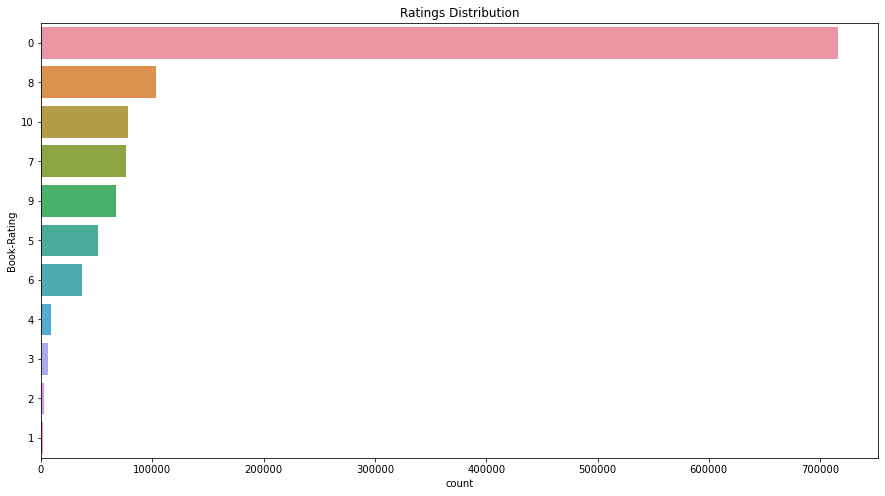

In [106]:
#checking the distribution of ratings
count_plot('Book-Rating', ratings, 'Ratings Distribution')

The ratings are unevenly distributed since majority of the ratings are 0. The ratings are either explicit, expressed on a scale of 1-10 with higher values denoting higher appreciation, or implicit, expressed by 0. Hence the need to segragate implicit and explict ratings datasets

In [107]:
#segregating implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings['Book-Rating'] != 0]
ratings_implicit = ratings_new[ratings['Book-Rating'] == 0]

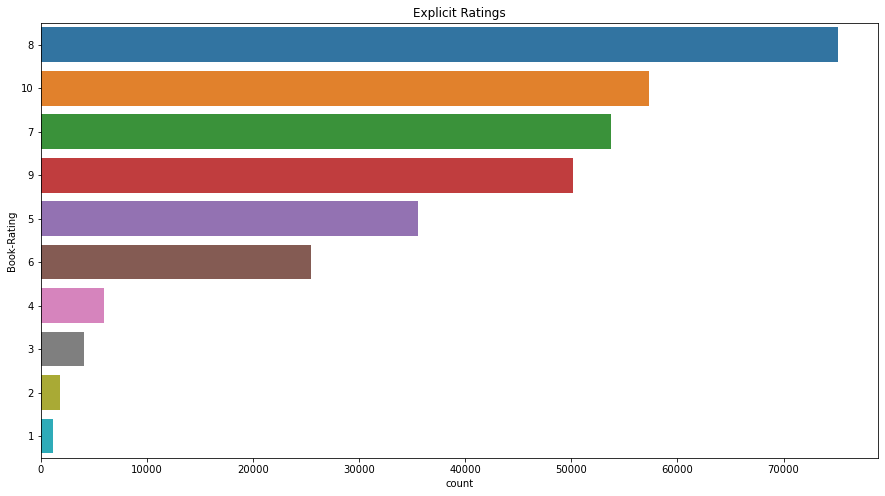

In [108]:
#plotting the explicit ratings
count_plot('Book-Rating', ratings_explicit, 'Explicit Ratings')

It can be observed that higher ratings are most common amongst users and rating 8 has been rated the highest number of times.

In [109]:
#finding the top 5 books that are rated most
rating_count = pd.DataFrame(ratings_explicit.groupby('ISBN')['Book-Rating'].count())
rating_count.sort_values('Book-Rating', ascending=False).head()

,Book-Rating
ISBN,
0316666343,707
0971880107,581
0385504209,490
0312195516,383
059035342X,315


In [110]:
#discovering which book is displayed by the above ISBN numbers
most_rated_books = pd.DataFrame(['0316666343', '0971880107', '0385504209', '0312195516', '0060928336'], index=np.arange(5), columns = ['ISBN'])
most_rated_books_summary = pd.merge(most_rated_books, book_data, on='ISBN')
most_rated_books_summary

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
0,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,Alice Sebold,"The spirit of fourteen-year-old Susie Salmon describes her murder, her surprise at her new home in heaven, and her witness to her family's grief, efforts to find the killer, and attempts to come to terms with what has happened. A first novel. Reprint. 50,000 first printing.",372,Fiction,not_mature,en
1,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,Rich Shapero,"Wild animus is a search for the primordial, a test of human foundations and a journey to the breaking point.",328,Fiction,not_mature,en
2,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,Dan Brown,"Harvard symbologist Robert Langdon and French cryptologist Sophie Neveu work to solve the murder of an elderly curator of the Louvre, a case which leads to clues hidden in the works of Da Vinci and a centuries-old secret society.",472,Fiction,not_mature,en
3,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,Anita Diamant,"Her name is Dinah. In the Bible, her life is only hinted at in a brief and violent detour within the more familiar chapters of the Book of Genesis that are about her father, Jacob, and his dozen sons. Told in Dinah's voice, this novel reveals the traditions and turmoils of ancient womanhood--the world of the red tent. It begins with the story of her mothers--Leah, Rachel, Zilpah, and Bilhah--the four wives of Jacob. They love Dinah and give her gifts that sustain her through a hard-working youth, a calling to midwifery, and a new home in a foreign land. Dinah's story reaches out from a remarkable period of early history and creates an intimate connection with the past. Deeply affecting, The Red Tent combines rich storytelling with a valuable achievement in modern fiction: a new view of biblical women's society.",336,Fiction,not_mature,en


Majority of the books that had a high rating are mainly of category fiction and are all novels. This shows that novels of type fiction are mainly preferred by users

In [111]:
# Create column Rating average consisting the mean of the explicit ratings
ratings_explicit['Avg_Rating']=ratings_explicit.groupby('ISBN')['Book-Rating'].transform('mean')
# Create column Total-No-Of-Users-Rated consisting the count of explicit ratings 
ratings_explicit['Total_No_Of_Users_Rated']=ratings_explicit.groupby('ISBN')['Book-Rating'].transform('count')

In [112]:
ratings_explicit.head()

,User-ID,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated
3,276729,052165615X,3,3.000000,1
4,276729,0521795028,6,6.000000,1
16,276747,0060517794,9,8.000000,30
19,276747,0671537458,9,7.176471,17
20,276747,0679776818,8,7.476190,21


In [113]:
#merging explicit ratings to the users dataset and published2 dataset
Final_Dataset=users.copy()
Final_Dataset=pd.merge(Final_Dataset,ratings_explicit,on='User-ID')
Final_Dataset=pd.merge(Final_Dataset,book_data,on='ISBN')

In [114]:
Final_Dataset.head()

,User-ID,Age,City,State,Country,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,authors,description,page_count,categories,maturity_rating,language
0,8,32,timmins,ontario,canada,074322678X,5,5.0,1,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,http://images.amazon.com/images/P/074322678X.01.THUMBZZZ.jpg,Ann Beattie,"Now back in print, Ann Beattie's finest short story collection, reissued to accompany the publication of her latest novel, ""The Doctor's House."" Most of the characters in ""Where You'll Find Me"" grew up in the 1960s and 1970s, are in their twenties and thirties and embody a curious, yet familiar, fusion of hope and despair. In finely crafted narratives, Beattie writes of women nursing broken hearts, men looking for love, and married couples struggling to stay together.",207,Fiction,not_mature,en
1,8,32,timmins,ontario,canada,0887841740,5,5.0,1,The Middle Stories,Sheila Heti,2004,House of Anansi Press,http://images.amazon.com/images/P/0887841740.01.THUMBZZZ.jpg,Sheila Heti,"Part Dorothy Parker, part Jose Saramago, with shades of George Orwell, Sheila Heti has arrived on Canada's literary scene a fully formed artist. Balancing wisdom and innocence, joy and foreboding, each story in The Middle Stories leads us to surprising places. A frog doles out sage advice to a plumber infatuated with a princess, a boy falls hopelessly in love with a monkey, and a man with a hat keeps apocalyptic thoughts at bay by resolving to follow a plan that he admits he won't stick to. Globe and Mail critic Russell Smith has described Heti's stories as cryptic fairy tales without morals at the end, but really the morals are in the quality of the telling and in the details disclosed along the way. Look where you weren't going to look, think what you wouldn't have thought, Heti seems to say, and meaning itself gains more meaning and more dimensions. Heti's stories are not what you expect, but why did you expect that anyway?""",144,Fiction,not_mature,en
2,8,32,timmins,ontario,canada,1575663937,6,6.0,1,More Cunning Than Man: A Social History of Rats and Man,Robert Hendrickson,1999,Kensington Publishing Corp.,http://images.amazon.com/images/P/1575663937.01.THUMBZZZ.jpg,Robert Hendrickson,"This eye-opening, well-researched examination of mankind's oldest competitor is filled with weirdly fascinating information about the history of the rat and the way it consistently outsmarts man. Illustrations.",300,Nature,not_mature,en
3,8,32,timmins,ontario,canada,1881320189,7,7.0,2,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,http://images.amazon.com/images/P/1881320189.01.THUMBZZZ.jpg,Julia Oliver,"A beautifully narrated novel of time and place, ""Goodbye to the Buttermilk Sky"" re-creates a southern summer when the depression and the boll weevil turned hopes to dust. With the extraordinary talent to make the reader see the Ball canning jars on the kitchen table, hear the clicks on the party line, and feel the bittersweet moments of 20-year-old Callie Tatum's first experiences with adult desire, Oliver portrays a young wife's increasingly dangerous infidelity with cinematic precision and palpable suspense.",191,Fiction,not_mature,en
4,226745,38,humble,other,other,1881320189,7,7.0,2,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,http://images.amazon.com/images/P/1881320189.01.THUMBZZZ.jpg,Julia Oliver,"A beautifully narrated novel of time and place, ""Goodbye to the Buttermilk Sky"" re-creates a southern summer when the depression and the boll weevil turned hopes to dust. With the extraordinary talent to make the reader see the Ball canning jars on the kitchen table, hear the clicks on the party line, and feel the bittersweet moments of 20-year-old Callie Tatum's first experiences with adult desire, Oliver portrays a young wife's increasingly dangerous infidelity with cinematic precision and palpable suspense.",191,Fiction,not_mature,en


In [115]:
#Instantiate the 'DescribeData' class for the 'Final_dataset' 
fd = DescribeData(Final_Dataset)

In [116]:
#checking for missing values in the combined dataset to be used for analysis
print(fd.missing)

There are a total of 0 missing values in the DataFrame.

User-ID                    0
Age                        0
City                       0
State                      0
Country                    0
ISBN                       0
Book-Rating                0
Avg_Rating                 0
Total_No_Of_Users_Rated    0
Book-Title                 0
Book-Author                0
Year-Of-Publication        0
Publisher                  0
Image-URL-S                0
authors                    0
description                0
page_count                 0
categories                 0
maturity_rating            0
language                   0
dtype: int64


### Exploratory Data Analysis

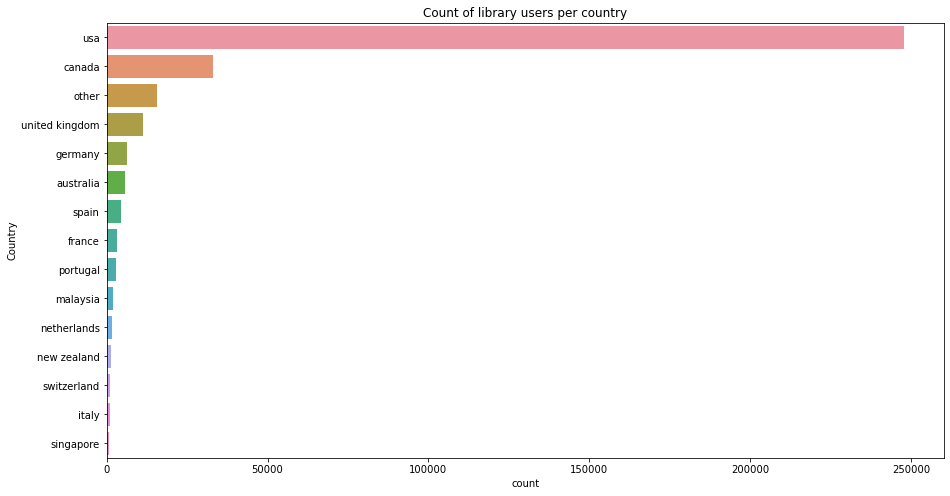

In [117]:
#plotting the count of users per country
count_plot('Country', Final_Dataset, 'Count of library users per country')

>Majority of library users are based in USA and Canada while Singapore and Italy have the least number of library users.

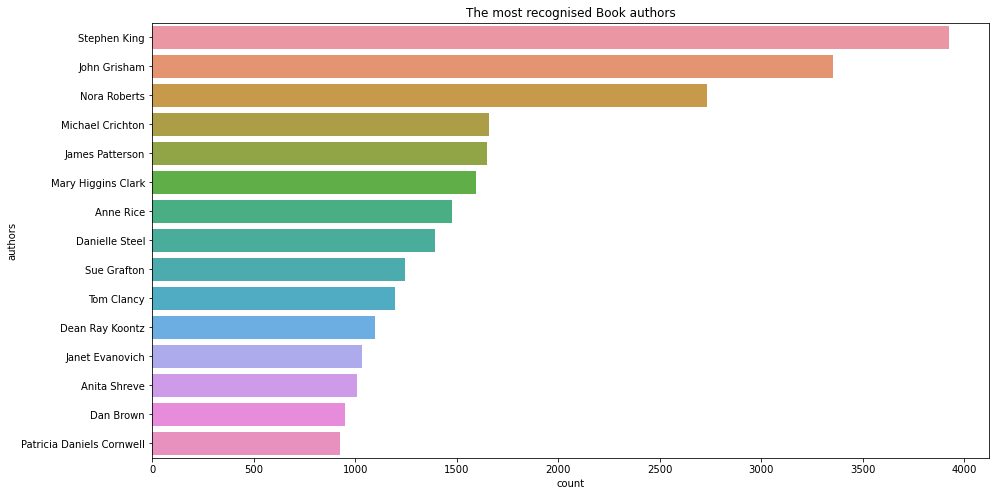

In [118]:
#plotting the most recognised book authors 
count_plot('authors', Final_Dataset, 'The most recognised Book authors')

>The most recognised book authors are Stephen King and John Grisham. On the other hand, Dan Brown and Patricia Dniels Cornwell are the least recognised book authors.

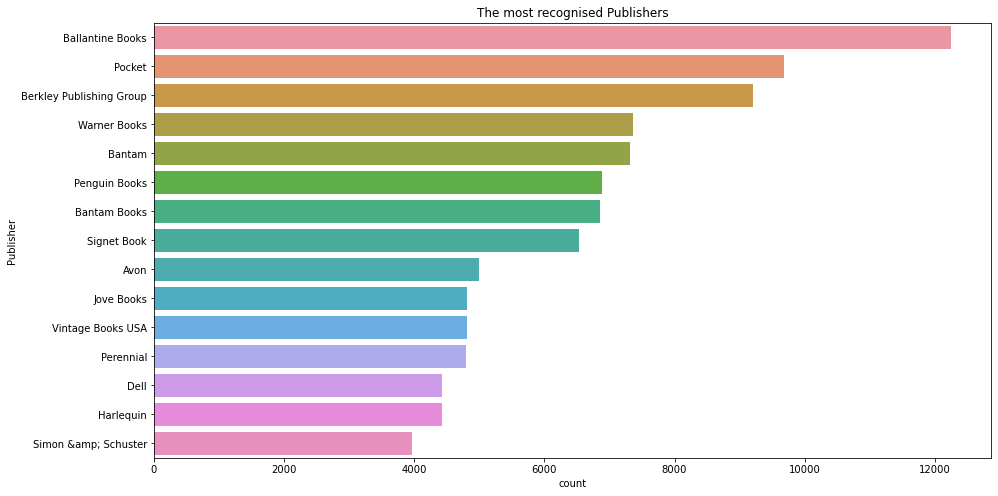

In [119]:
#plotting the most recognised publishers
count_plot('Publisher', Final_Dataset, 'The most recognised Publishers')

>The most recognised publisher is Ballantine Books and Pocket while the least recognised publisher is Harlequin and Simon &amp Schuster.